In [2]:
import pandas as pd
import numpy as np

In [3]:
np.random.seed(42)

In [ ]:
#Dataset source 
#https://earthdata.nasa.gov/earth-observation-data/near-real-time/firms/viirs-i-band-active-fire-data

#Intro to basic numpy functions: 
#https://docs.google.com/document/d/e/2PACX-1vR0XrFeBDwGebi2Qwpu1q61eCkqdLovh9xs_-xJIDMmGE1ZmsQ-gGUSieHgxURG2Fw9XLCmi1MilPNw/pub
#Intro to basic pandas functions: 
#https://docs.google.com/document/d/e/2PACX-1vQIMRh9GUuiKh8w2EDvj2-MSdYsuZ1sqTXqIL_AsWYZALsXPTJirjMAbMgdwG8Lm5kACPWPk8rCzz9w/pub


In [51]:
#Other reference for data normalization/standardization 
#https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/
def minmaxnorm(data_in):
    minimum = np.min(data_in)
    maximum = np.max(data_in)
    return (data_in - minimum)/(maximum-minimum)

#One hot encoding is another widely used technique for featurization (not used here)
#https://www.kaggle.com/dansbecker/using-categorical-data-with-one-hot-encoding
#Useful for encoding sets of items. 

def get_features(csv_path):
    data = pd.read_csv(csv_path)
    #We are dropping columns 'Unnamed: 0', 'instrument', 'version' :  which contain no info
    #We drop 'frp' since it is target variable Y (not included in feature matrix X)
    #We droped 'date' here since encoding it is non trivial 
    #Once pointer for encodign date: 
    #https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
    data = data.drop(columns=['Unnamed: 0','acq_date', 'instrument', 'version', 'frp' ])

    #Since satellite feature takes only 2 values, we used 0/1 for representation
    #If satellite feature could take >2 values, we would have used 1-hot encoding
    data['satellite'] = data['satellite'].str.replace('Terra','0')
    data['satellite'] = data['satellite'].str.replace('Aqua','1')
    data['satellite'] = pd.to_numeric(data['satellite'] )

    data['daynight'] = data['daynight'].str.replace('D','0')
    data['daynight'] = data['daynight'].str.replace('N','1')
    data['daynight'] = pd.to_numeric(data['daynight'] )
    
    #Imp: feature scaling. 
    numpy_data = data.to_numpy()
    norm_np_data = np.apply_along_axis(minmaxnorm,0,numpy_data)
    
    #Add bias:  [w]^T [X] + B == [W;B]^T [X;1]
    bias_data = np.hstack((norm_np_data,np.ones((norm_np_data.shape[0],1),dtype=norm_np_data.dtype)))
    return bias_data

def get_targets(csv_path):
    data = pd.read_csv(csv_path)
    target = data['frp'].to_numpy()
    return target

In [53]:
csv_path = 'data/train.csv'
train_features = get_features(csv_path)
train_targets = get_targets(csv_path)
csv_path = 'data/dev.csv'
dev_features = get_features(csv_path)
dev_targets = get_targets(csv_path)

In [68]:
# W* = (X^TX)^-1 X^T Y 
def get_analytical_solution(feature_matrix, targets):
    return np.matmul(np.linalg.inv(np.matmul(feature_matrix.T,feature_matrix) + np.eye(feature_matrix.shape[1])*1e-8),\
np.matmul(feature_matrix.T,targets))

In [ ]:
a_solution = get_analytical_solution(train_features,train_targets)

In [75]:
def evaluation(features,targets,weights): 
    #Use W* and X_dev to compute Ypred_dev
    predictions = np.matmul(features,weights)
    #Compute MSE loss on Ypred_dev and Y_dev
    loss = np.matmul(predictions - targets,predictions - targets)
    return loss/features.shape[0]

In [80]:
dev_loss = evaluation(dev_features,dev_targets,a_solution)

In [77]:
train_loss = evaluation(train_features,train_targets,a_solution)

In [81]:
train_loss, dev_loss

(26023.865414732256, 39045.785858989584)

In [82]:
#RANKING LOSS DEMO - IMPORTANCE OF TENSORIZATION 

In [98]:
import torch
import time


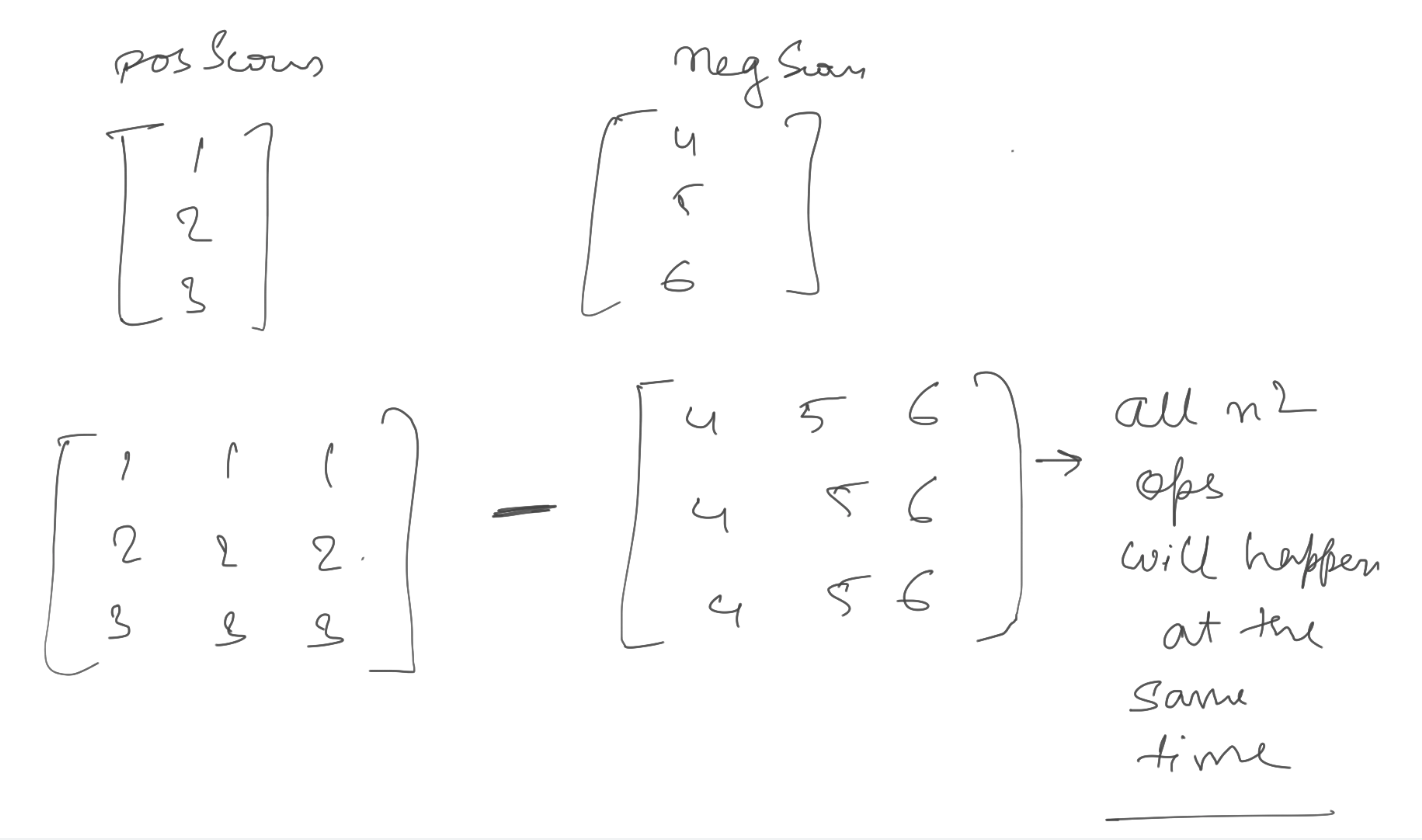

In [180]:
from IPython.display import Image

Image(filename = "tensorization.png", width=500, height=500)


In [168]:
#Setup :Ranking loss
#Your model scores a set of positive items (posScores) 
#and a set of negative items (negScores)
#Desirable property: positive items ranked higher than negative aka posScores >negScores
#Undesirable : negScores > posScores
#Hence we need to do pairwise comparison of all posScores and negScores
#And penalize every occurence on negScores being greater than posScores by adding it to the loss

#Additional NOTE: Usually there is a margin associated with such loss terms
#Concept of margin will be discussed in class later 

#This would be the usual way of coding ranking loss
def pairwise_sequential(posScores,negScores):
    s = time.time()
    loss=0
    for i in range(len(posScores)):
        for j in range(len(negScores)):
            #Relu is the same as max(0,v)
            loss = loss + torch.nn.ReLU()(negScores[j]-posScores[i])
    val = loss/(len(posScores)*len(negScores))
    return val,time.time()-s

#This is tensorized version of the ranking loss computation 
#which leverages parallel processing support
def pairwise_parallel(posScores,negScores):
    predPos = posScores.unsqueeze(1)
    predNeg = negScores.unsqueeze(1)
    s = time.time()
    n_1 = predPos.shape[0]
    n_2 = predNeg.shape[0]
    dim = predPos.shape[1]

    expanded_1 = predPos.unsqueeze(1).expand(n_1, n_2, dim)
    expanded_2 = predNeg.unsqueeze(0).expand(n_1, n_2, dim)
    ell = expanded_2 - expanded_1
    hinge = torch.nn.ReLU()
    loss = hinge(ell)
    sum_loss =  torch.sum(loss,dim= [0, 1])
    return (sum_loss/(n_1*n_2)).squeeze(),time.time()-s

In [171]:
time_parallel = []
time_seq = [] 
for seq_len in range(1,100):
    posScores = torch.rand(seq_len)
    negScores = torch.rand(seq_len)
    v_par, t_par = pairwise_parallel( posScores, negScores)
    v_seq, t_seq = pairwise_sequential( posScores, negScores)
    #Assert confirms that the values of the parallel and sequential 
    #implementations are same
    assert (torch.isclose(v_par,v_seq))
    #Note: equality checks sometimes fail because of floating point errors of small magnitude
    #Following does not always work. Use isclose() instead
    #assert(v_par==v_seq)
    time_parallel.append(t_par)
    time_seq.append(t_seq)

In [ ]:
#NOTE: As sequence length increases, 
# the execution time for parallel remains more or less constance
#while the execution time for sequential rapidly increases (O(n^2))

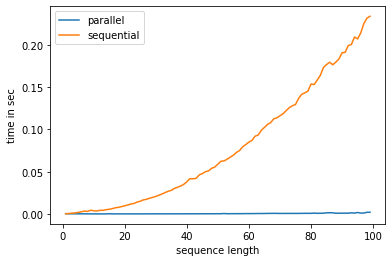

In [179]:
from matplotlib import pyplot as plt
plt.plot(list(range(1,100)),time_parallel,label='parallel')
plt.plot(list(range(1,100)),time_seq,label='sequential')
plt.ylabel("time in sec",fontsize=10)
plt.xlabel("sequence length",fontsize=10)
plt.legend()
plt.show()